# Baseline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Colab Notebooks'

/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=11815030aba2c7ea0fdcc76361138b65073c7e4422d1f86b8f6ec70aecf3e760
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import import_ipynb
import numpy as np
import Utils as utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

importing Jupyter notebook from Utils.ipynb
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Utilities

In [ ]:
# seen on: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class PairGenerator(tf.keras.utils.Sequence):
  def __init__(self, right, left):
    self.right = right
    self.left = left

  def __len__(self):
    return len(self.right)
  
  def __getitem__(self, i):
    right_sample,right_label = self.right[i]
    left_sample,left_label = self.left[i]
    return (right_sample,left_sample), right_label

In [ ]:
def create_siamese_dataset(images, labels):
  dataset = []
  ids = []
  for i in range(0,images.shape[0], 2):
    dataset += [[images[i], images[i+1]]]
    if (labels[i+1] == 1 or labels[i+1] == 2):
      ids += [0] #mass
    else:
      ids += [1] #calcification
  return dataset, ids

## Data preprocessing

In [ ]:
BATCH_SIZE = 32

In [ ]:
#Import training set
images, labels = utils.load_training()

In [ ]:
images = utils.rescale(images)
images = np.expand_dims(images, axis=3)
utils.properties(images)

Properties: 
Shape: (5352, 150, 150, 1)
Min: 0.0
Max: 1.0
Diff: 1.0
Type of elements: float64


In [ ]:
dataset, ids = create_siamese_dataset(images, labels)
dataset, ids = utils.shuffle_dataset(dataset, ids)
dataset = np.array(dataset)
t_set, v_set, t_lab, v_lab = train_test_split(dataset, ids, test_size=0.2, stratify=ids)

In [ ]:
data_augmentation = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

right_train = data_augmentation.flow(t_set[:,0], t_lab, batch_size=BATCH_SIZE, seed=42)
left_train = data_augmentation.flow(t_set[:,1], t_lab, batch_size=BATCH_SIZE, seed=42)

train_set = PairGenerator(right_train, left_train)

right_valid = data_augmentation.flow(v_set[:,0], v_lab, batch_size=BATCH_SIZE, seed=42)
left_valid = data_augmentation.flow(v_set[:,1], v_lab, batch_size=BATCH_SIZE, seed=42)

valid_set = PairGenerator(right_valid, left_valid)

In [ ]:
weights = class_weight.compute_class_weight('balanced', np.unique(ids), ids)
weights = dict(enumerate(weights))

## Training

### Network architecture

In [ ]:
# sister network for siamese architecture
sister = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 5, activation='relu'),
      tf.keras.layers.MaxPool2D(),
      tf.keras.layers.Conv2D(64, 5, activation='relu'),
      tf.keras.layers.MaxPool2D(),
      tf.keras.layers.Conv2D(128, 5, activation='relu'),
      tf.keras.layers.MaxPool2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu')
])

# siamese network using functional API
input_right = tf.keras.layers.Input(shape=(150,150,1), name='input_right')
input_left = tf.keras.layers.Input(shape=(150,150,1), name='input_left')

sister_right = sister(input_right)
sister_left = sister(input_left)

distance = tf.keras.layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
distance_layer = distance([sister_left, sister_right])

prediction = tf.keras.layers.Dense(1, activation='sigmoid')(distance_layer)

siamese_net = tf.keras.Model(inputs=[input_right, input_left], outputs=prediction)
siamese_net.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_left (InputLayer)         [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
input_right (InputLayer)        [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 256)          15134464    input_right[0][0]                
                                                                 input_left[0][0]                 
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 256)          0           sequential_6[1][0]         

In [ ]:
siamese_net.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                   mode='max', 
                                   patience=20,  
                                   restore_best_weights=True),
             
  tf.keras.callbacks.ModelCheckpoint('models/siamese_32_2.h5', 
                                     monitor='val_accuracy', 
                                     mode='max',
                                    save_best_only=True)]

history = siamese_net.fit(train_set, 
                          shuffle=True, 
                          validation_data=valid_set,
                          batch_size = BATCH_SIZE, 
                          class_weight=weights,
                          callbacks=callbacks,
                          epochs=100, 
                          verbose = 1)

Epoch 1/100
67/67 [==============================] - 10s 141ms/step - loss: 0.6853 - accuracy: 0.5132 - val_loss: 0.6520 - val_accuracy: 0.6157
Epoch 2/100
67/67 [==============================] - 9s 136ms/step - loss: 0.6502 - accuracy: 0.6275 - val_loss: 0.5845 - val_accuracy: 0.7313
Epoch 3/100
67/67 [==============================] - 9s 136ms/step - loss: 0.6339 - accuracy: 0.6522 - val_loss: 0.6004 - val_accuracy: 0.6772
Epoch 4/100
67/67 [==============================] - 9s 138ms/step - loss: 0.6025 - accuracy: 0.6808 - val_loss: 0.5614 - val_accuracy: 0.7369
Epoch 5/100
67/67 [==============================] - 9s 136ms/step - loss: 0.5971 - accuracy: 0.7165 - val_loss: 0.5695 - val_accuracy: 0.7090
Epoch 6/100
67/67 [==============================] - 9s 141ms/step - loss: 0.5687 - accuracy: 0.7453 - val_loss: 0.5251 - val_accuracy: 0.7910
Epoch 7/100
67/67 [==============================] - 9s 137ms/step - loss: 0.5499 - accuracy: 0.7509 - val_loss: 0.4995 - val_accuracy: 0.796

### Training plots

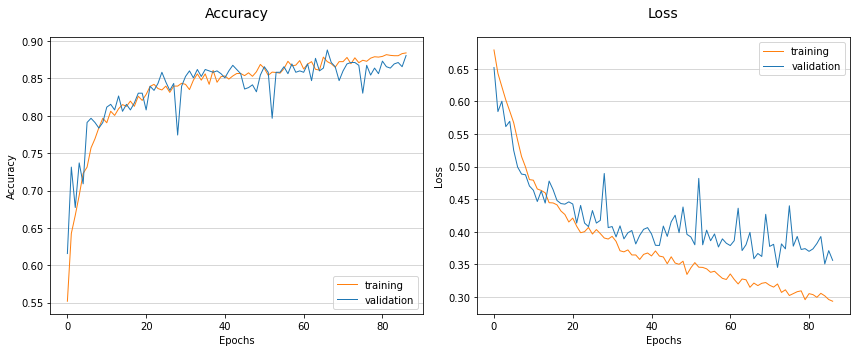

In [ ]:
utils.plot_training(history.history['accuracy'],
                    history.history['loss'],
                    history.history['val_accuracy'],
                    history.history['val_loss'],
                    87,
                    'figures/siamese_32_2.png')

## Evaluation

In [ ]:
test_images, test_labels = utils.load_test()
test_images = utils.rescale(test_images)
test_images = np.expand_dims(test_images, axis=3)
utils.properties(test_images)

Properties: 
Shape: (672, 150, 150, 1)
Min: 0.0
Max: 1.0
Diff: 1.0
Type of elements: float64


In [ ]:
test_set, test_ids = create_siamese_dataset(test_images, test_labels)
test_set, test_ids = utils.shuffle_dataset(test_set, test_ids)
test_set = np.array(test_set)
test_ids = np.array(test_ids)

In [ ]:
prediction = siamese_net.predict([test_set[:,0], test_set[:,1]], verbose=1)
prediction = [0 if x<= 0.5 else 1 for x in prediction]
utils.evaluate_classifier(test_ids, prediction)

11/11 [==============================] - 0s 20ms/step
Performances: 
Accuracy:  0.8184523809523809
Precision:  0.8273348675134388
Recall:  0.8184523809523809
F1-score:  0.8183317641282244
AUC:  0.8225634273920933


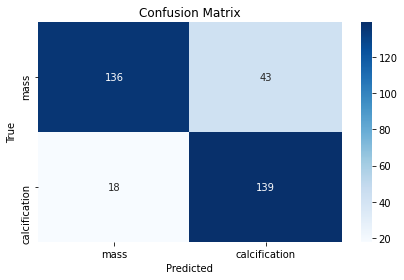

In [ ]:
utils.plot_confusion_matrix(test_ids, prediction, ['mass', 'calcification'], 'figures/siamese_cm_32_2.png')